In [72]:
import pandas as pd

In [73]:
eICU_data = pd.read_csv("C:\\Users\\lee39\\OneDrive\\Desktop\\final_merged_dataset.csv")

In [74]:
eICU_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35489 entries, 0 to 35488
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patientunitstayid    35489 non-null  int64  
 1   gender               35489 non-null  object 
 2   age                  35489 non-null  int64  
 3   ethnicity            35489 non-null  object 
 4   hospitalid           35489 non-null  int64  
 5   admission_type       35489 non-null  object 
 6   unitdischargestatus  35489 non-null  object 
 7   unitdischargeoffset  35489 non-null  int64  
 8   has_COPD             35489 non-null  float64
 9   has_Diabetes         35489 non-null  float64
 10  has_Metastasis       35489 non-null  float64
 11  has_Sepsis_A41_9     35489 non-null  float64
 12  GCS                  35489 non-null  float64
 13  vent                 35489 non-null  float64
 14  has_Vasopressor      35489 non-null  float64
 15  WBC x 1000           35489 non-null 

## Prepare data

In [75]:
df_clean = eICU_data.copy()

df_clean.index = df_clean["patientunitstayid"]
df_clean.drop(["patientunitstayid"], inplace=True, axis=1)

# Convert 'unitdischargestatus' to binary: 1 = Expired (death), 0 = Alive
df_clean['death'] = (df_clean['unitdischargestatus'] == 'Expired').astype(int)

# Convert time from minutes to days (for interpretability)
df_clean['survival_time_days'] = df_clean['unitdischargeoffset'] / (60 * 24)

# Also convert treatment to binary (just to be sure)
df_clean['treatment'] = df_clean['has_Vasopressor'].astype(int)

In [76]:
df_clean.head()

,gender,age,ethnicity,hospitalid,admission_type,unitdischargestatus,unitdischargeoffset,has_COPD,has_Diabetes,has_Metastasis,...,WBC x 1000,Hgb,platelets x 1000,total bilirubin,creatinine,albumin,anion gap,death,survival_time_days,treatment
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
242082,Male,75,Caucasian,108,Emergency,Alive,2752,0.0,0.0,0.0,...,7.18,13.1,169.0,20.52,69.836,4.1,11.0,0,1.911111,0
242083,Female,90,Caucasian,92,Emergency,Alive,1546,0.0,0.0,0.0,...,10.00,14.7,213.0,15.39,71.604,4.2,18.0,0,1.073611,0
242154,Female,46,Caucasian,79,Elective,Alive,8792,0.0,0.0,0.0,...,21.30,10.5,450.0,3.42,35.360,2.8,8.0,0,6.105556,0
242290,Female,75,Other/Unknown,79,Elective,Alive,1656,0.0,0.0,0.0,...,12.40,11.1,239.0,6.84,141.440,2.6,9.0,0,1.150000,0
242319,Male,61,Caucasian,79,Elective,Alive,1856,0.0,0.0,0.0,...,9.10,9.1,149.0,6.84,150.280,2.6,9.0,0,1.288889,0


In [77]:

# Display the proportion of deaths and treatment assignment
death_rate = df_clean['death'].mean()
treatment_rate = df_clean['treatment'].mean()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35489 entries, 242082 to 3353254
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               35489 non-null  object 
 1   age                  35489 non-null  int64  
 2   ethnicity            35489 non-null  object 
 3   hospitalid           35489 non-null  int64  
 4   admission_type       35489 non-null  object 
 5   unitdischargestatus  35489 non-null  object 
 6   unitdischargeoffset  35489 non-null  int64  
 7   has_COPD             35489 non-null  float64
 8   has_Diabetes         35489 non-null  float64
 9   has_Metastasis       35489 non-null  float64
 10  has_Sepsis_A41_9     35489 non-null  float64
 11  GCS                  35489 non-null  float64
 12  vent                 35489 non-null  float64
 13  has_Vasopressor      35489 non-null  float64
 14  WBC x 1000           35489 non-null  float64
 15  Hgb                  35489 no

In [78]:
df_clean[['death', 'survival_time_days', 'treatment']].head(), death_rate, treatment_rate

(                   death  survival_time_days  treatment
 patientunitstayid                                      
 242082                 0            1.911111          0
 242083                 0            1.073611          0
 242154                 0            6.105556          0
 242290                 0            1.150000          0
 242319                 0            1.288889          0,
 0.07295218236636704,
 0.05410127081630928)

## Estimated the propensity scores using logistic regression.

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define reasonable covariates based on clinical relevance and paper practices
covariates = [
    'age', 'GCS', 'vent', 'has_COPD', 'has_Diabetes', 'has_Metastasis',
    'has_Sepsis_A41_9', 'WBC x 1000', 'Hgb', 'platelets x 1000',
    'total bilirubin', 'creatinine', 'albumin', 'anion gap'
]

# Drop any rows with missing values in the selected variables
df_ps = df_clean.dropna(subset=covariates + ['treatment'])

# Fit logistic regression model to estimate the propensity score
X = df_ps[covariates]
y = df_ps['treatment']

# Standardize features and fit logistic regression
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_reg.fit(X, y)

# Predict propensity scores (probability of being treated)
df_ps['propensity_score'] = log_reg.predict_proba(X)[:, 1]

# Display summary of propensity scores
df_ps[['treatment', 'propensity_score']].describe()


,treatment,propensity_score
count,35489.000000,35489.000000
mean,0.054101,0.054101
std,0.226221,0.035264
min,0.000000,0.000540
25%,0.000000,0.031021
50%,0.000000,0.046701
75%,0.000000,0.068041
max,1.000000,0.694124


## Compute IPTW weights (Cole & Hernán)

In [80]:
t = df_ps['treatment']
ps = df_ps['propensity_score']
df_ps['iptw_weight'] = t / ps + (1 - t) / (1 - ps)

# Show descriptive statistics of the weights
df_ps['iptw_weight'].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

count    35489.000000
mean         1.978735
std          4.716184
min          1.000540
1%           1.009501
5%           1.016220
50%          1.050099
95%          7.019020
99%         24.580191
max        166.965596
Name: iptw_weight, dtype: float64

## Plot IPTW-Adjusted Survival Curves

D:\anaconda3\envs\FLCausalMixture\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:307: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
D:\anaconda3\envs\FLCausalMixture\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:307: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using in

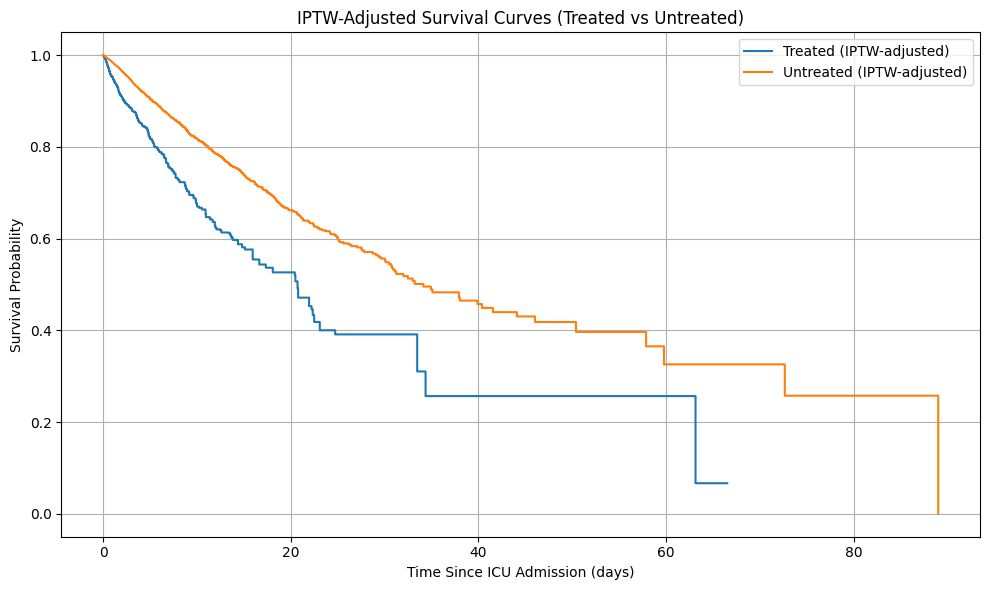

In [81]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Divide the data
df_treated = df_ps[df_ps['treatment'] == 1].copy()
df_untreated = df_ps[df_ps['treatment'] == 0].copy()

# Initialize Kaplan-Meier fitters
kmf_treated = KaplanMeierFitter()
kmf_untreated = KaplanMeierFitter()

# Plot setup
plt.figure(figsize=(10, 6))

# Fit and plot treated group
kmf_treated.fit(
    durations=df_treated['survival_time_days'],
    event_observed=df_treated['death'],
    weights=df_treated['iptw_weight'],
    label='Treated (IPTW-adjusted)'
)
kmf_treated.plot_survival_function(ci_show=False)

# Fit and plot untreated group
kmf_untreated.fit(
    durations=df_untreated['survival_time_days'],
    event_observed=df_untreated['death'],
    weights=df_untreated['iptw_weight'],
    label='Untreated (IPTW-adjusted)'
)
kmf_untreated.plot_survival_function(ci_show=False)

# Final plot settings
plt.title('IPTW-Adjusted Survival Curves (Treated vs Untreated)')
plt.xlabel('Time Since ICU Admission (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Estimate Median Survival (IPTW)

In [82]:

# Get median survival times
treated_median = kmf_treated.median_survival_time_
untreated_median = kmf_untreated.median_survival_time_

# Print results
print(f"Median Survival (Treated):   {treated_median:.2f} days")
print(f"Median Survival (Untreated): {untreated_median:.2f} days")
print(f"Difference (Untreated - Treated): {untreated_median - treated_median:.2f} days")


Median Survival (Treated):   20.72 days
Median Survival (Untreated): 34.14 days
Difference (Untreated - Treated): 13.41 days


# Simulation Pipeline

## Step 1: Simulate Covariates for 10,000 Patients

In [83]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Sample size
n = 10000

# Simulate 10 baseline covariates: X1 to X10 ~ N(0,1)
X = np.random.normal(0, 1, size=(n, 10))
columns = [f'X{i+1}' for i in range(10)]
df = pd.DataFrame(X, columns=columns)

In [84]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040
...,...,...,...,...,...,...,...,...,...,...
9995,0.677505,-0.629625,0.051052,-1.175068,0.263150,-1.589500,-1.319203,0.303600,0.878780,0.040772
9996,1.383249,0.407372,-0.555289,1.331587,0.552332,0.483994,1.398952,-0.370326,0.664494,-0.493281
9997,0.001128,-1.047569,0.282285,0.758322,-0.079564,0.350220,-2.221678,0.452383,-1.312673,1.031308
9998,0.928169,-0.887350,-0.540580,1.376140,1.340871,0.444651,-0.515283,-1.828546,0.739981,-0.590794


## Step 2: Assign Treatment Using a Propensity Score Model

In [85]:
from scipy.special import expit  # logistic sigmoid function

# True coefficients for treatment assignment (based on X1 to X7)
beta_treat = np.array([0.6, -0.4, 0.8, -0.6, 0.5, -0.7, 0.9])  # length 7
intercept = -2.5  # Adjust this to control treatment prevalence

# Linear predictor for treatment model
lin_pred_treat = intercept + np.dot(df[[f'X{i+1}' for i in range(7)]], beta_treat)

# Propensity scores (probability of treatment)
propensity_scores = expit(lin_pred_treat)

# Simulate treatment: 1 = treated, 0 = untreated
df['treatment'] = np.random.binomial(1, propensity_scores)
df['propensity_score'] = propensity_scores

In [86]:
treatment_rate = df['treatment'].mean()
print(f"Proportion treated: {treatment_rate:.2%}")

Proportion treated: 15.82%


## Step 3: Simulate Survival Times Using a Known Hazard Model

In [87]:
# Coefficients for survival model (affecting log hazard)
gamma_intercept = -3.5  # baseline hazard rate (controls average survival time)
gamma_treatment = np.log(1.5)
gamma_covariates = np.array([-0.3, 0.4, -0.2, 0.3, -0.1, 0.2, -0.25])  # for X4 to X10

# Linear predictor for log hazard
lin_pred_surv = (
    gamma_intercept
    + gamma_treatment * df['treatment']
    + np.dot(df[[f'X{i}' for i in range(4, 11)]], gamma_covariates)
)

# Convert to hazard rate (lambda = exp(linear predictor))
hazard_rates = np.exp(lin_pred_surv)
print(hazard_rates)

# Simulate survival times from exponential distribution
df['survival_time'] = np.random.uniform(0, 1, size=len(df)) / hazard_rates

# Set event indicator (all observed events, no censoring yet)
df['event'] = 1

0       0.021574
1       0.025545
2       0.023693
3       0.069549
4       0.027556
          ...   
9995    0.050546
9996    0.046775
9997    0.006336
9998    0.043220
9999    0.037736
Name: treatment, Length: 10000, dtype: float64


In [88]:
np.random.uniform(0, 1, size=len(df)) / hazard_rates

0        4.228279
1        2.010857
2       19.334332
3       12.932936
4       21.819694
          ...    
9995     4.865426
9996     1.087235
9997    85.836845
9998     1.782117
9999    19.196358
Name: treatment, Length: 10000, dtype: float64

In [89]:
df["survival_time"]

0        37.146780
1         0.138591
2        14.692659
3        14.237339
4        33.059793
           ...    
9995     18.518201
9996     10.306450
9997    104.454667
9998     12.825050
9999     23.835610
Name: survival_time, Length: 10000, dtype: float64

## 4: Apply Inverse Probability of Treatment Weighting (IPTW)

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from lifelines import CoxPHFitter

# Step 4.1: Re-estimate the propensity score using X1–X7
X_treat = df[[f'X{i+1}' for i in range(7)]]
y_treat = df['treatment']

ps_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
ps_model.fit(X_treat, y_treat)
df['ps_est'] = ps_model.predict_proba(X_treat)[:, 1]

# Step 4.2: Compute IPTW weights (Cole & Hernán style)
df['iptw'] = df['treatment'] / df['ps_est'] + (1 - df['treatment']) / (1 - df['ps_est'])

# Step 4.3: Fit a weighted Cox proportional hazards model
df_for_cox = df[['survival_time', 'event', 'treatment', 'iptw']]
cph = CoxPHFitter()
cph.fit(df_for_cox, duration_col='survival_time', event_col='event', weights_col='iptw')
cph.print_summary()


D:\anaconda3\envs\FLCausalMixture\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]
D:\anaconda3\envs\FLCausalMixture\lib\site-packages\lifelines\fitters\coxph_fitter.py:1354: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(
D:\anaconda3\envs\FLCausalMixture\lib\site-packages\lifelines\utils\printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base

<lifelines.CoxPHFitter: fitted with 19496.5 total observations, 0 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
              weights col = 'iptw'
      baseline estimation = breslow
   number of observations = 19496.5
number of events observed = 19496.5
   partial log-likelihood = -172261.75
         time fit was run = 2025-07-01 23:34:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
treatment   0.63       1.87       0.02             0.60             0.66                 1.82                 1.93

              z      p   -log2(p)
covariate                        
treatment 41.45 <0.005        inf
---
Concordance = 0.57
Partial AIC = 344525.50
log-likelihood ratio test = 1707.46 on 1 df
-log2(p) of ll-ratio test = inf